In [1]:
import numpy as np
from msmbuilder.feature_selection import VarianceThreshold
from msmbuilder.decomposition import tICA
from msmbuilder.cluster import MiniBatchKMeans
from msmbuilder.msm import MarkovStateModel
from sklearn.pipeline import Pipeline
from glob import glob
import pyemma.coordinates as coor
import pyemma.msm as msm
import pyemma.plots as mplt
import mdtraj as md

/Users/robert_arbon/anaconda/envs/ml4dyn/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/robert_arbon/anaconda/envs/ml4dyn/lib/python3.5/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)
/Users/robert_arbon/anaconda/envs/ml4dyn/lib/python3.5/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pa

You are still using msmtools from the deprecated Omnia channel. Please switch to conda-forge to catch future updates.
In order to do so please set conda-forge channel to highest priority by:

    conda config --add channels conda-forge

and update this package by:

    conda update msmtools




## Get Trial Data

In [2]:
import pandas as pd
trial_data = pd.read_pickle('best_trials.pickl')

In [3]:
trial_data.head()

,id,feature,strategy,cluster__n_clusters,tica__n_components,tica__lag_time,variance_cut__threshold,test_scores_mean,rank
3383,15,kappa_angle,csp,221,4,246,0.000169,4.298087,89.0
3417,53,omega_tor,csp,978,9,195,0.004492,5.690354,9.0
84,89,phi-o_tor,fixed,414,10,360,0.005813,2.988939,49.0
99,104,psi_tor,fixed,652,2,216,0.000290,2.990947,24.0
122,127,psi-o_tor,fixed,184,2,101,0.008936,2.986746,98.0


## Choose trial to investigate

In [4]:
trial_data['ts_gap'] = np.nan
trial_data['ts_gap_5pc'] = np.nan
trial_data['ts_gap_95pc'] = np.nan
trial_data['state_fraction'] = np.nan
trial_data['n_csp'] = np.nan

In [5]:
strategy = 'fixed'
rank = 2.0

In [6]:
trial = trial_data.loc[(trial_data['strategy']==strategy) & (trial_data['rank']==rank), :].to_dict()
trial_idx = list(trial_data.loc[(trial_data['strategy']==strategy) & (trial_data['rank']==rank), :].index)[0]

In [7]:
trial_index = trial_data.loc[(trial_data['strategy']==strategy) & (trial_data['rank']==rank), :].index


In [8]:
froot = str(strategy)+'-'+str(int(rank))

In [9]:
trial_id = trial['id'][trial_idx]
feature= trial['feature'][trial_idx]
n_clusters = int(trial['cluster__n_clusters'][trial_idx])
n_components = int(trial['tica__n_components'][trial_idx])
lag_time = int(trial['tica__lag_time'][trial_idx])
var_cut = float(trial['variance_cut__threshold'][trial_idx])


In [10]:
print('Trial ID        {}'.format(trial_id))
print('Feature         {}'.format(feature))
print('n_clusters      {}'.format(n_clusters))
print('n_components    {}'.format(n_components))
print('lag_time        {}'.format(lag_time))
print('variance cutoff {}'.format(var_cut))

Trial ID        2283
Feature         kappa_angle
n_clusters      255
n_components    2
lag_time        430
variance cutoff 0.0007977015943187404


## Filter the trajectories using MSMBuilder

In [11]:
traj_paths = glob('/Users/robert_arbon/Datasets/DHFR/train/'+feature+'/*.npy')

In [12]:
ftrajs = [np.load(path) for path in traj_paths]

In [13]:
pipe = Pipeline([('variance', VarianceThreshold(threshold=var_cut)), 
                ('tica', tICA(lag_time = lag_time, n_components=n_components)), 
                ('cluster', MiniBatchKMeans(n_clusters=n_clusters))])

In [14]:
total_ts = 20
from msmbuilder.msm import BayesianMarkovStateModel, MarkovStateModel


def bayes(dtrajs, n_csp=None):
    mm = BayesianMarkovStateModel(lag_time=50, n_samples=1000, n_chains=4)
    mm.fit(dtrajs)
    ts_df = pd.DataFrame(data=mm.all_timescales_[:,:total_ts])
    ts_df = pd.melt(ts_df, var_name='Process', value_name='Timescale')
    ts_df['Process'] += 1 
    med_ts = ts_df.groupby('Process').aggregate(np.median).values.flatten()
    if n_csp is None: 
        ratios = med_ts[:-1]/med_ts[1:]
        med_gap = np.max(ratios)
        n_csp = np.argmax(ratios)+1
        return n_csp, med_gap
    if n_csp is not None: 
        slowest_fast = ts_df.loc[ts_df['Process']==n_csp+1, 'Timescale'].values
        fastest_slow = ts_df.loc[ts_df['Process']==n_csp, 'Timescale'].values
        n_samples = int(1e5)
        gaps = np.zeros(n_samples)
        for i in range(n_samples):
            idx = np.random.randint(0, len(slowest_fast))
            fast = slowest_fast[idx]
            slow = fastest_slow[idx]    
            gaps[i] = slow/fast
        med_gap = np.median(gaps)
        return n_csp, med_gap
    
def mle(dtrajs, n_csp=None):
    mm = MarkovStateModel(lag_time=50)
    mm.fit(dtrajs)
    ts = mm.timescales_[:total_ts]
    if n_csp is None: 
        ratios = ts[:-1]/ts[1:]
        gap = np.max(ratios)
        n_csp = np.argmax(ratios)+1
        return n_csp, gap
    if n_csp is not None: 
        fastest_slow = ts[n_csp-1]
        slowest_fast = ts[n_csp]
        gap = fastest_slow/slowest_fast
        return n_csp, gap  


In [16]:
from sklearn.model_selection import ShuffleSplit
cv = ShuffleSplit(n_splits=50, test_size=0.5, random_state=42)
results = {'method': [], 
           'n_csp': [],
           'gap': []
          }
for train_idx, test_idx in cv.split(ftrajs):
    train = [ftrajs[idx] for idx in train_idx]
    tr_dtrajs = pipe.fit_transform(train)
#     test = [ftrajs[idx] for idx in test_idx]
#     te_dtrajs = pipe.transform(test)


    # Calculate n_csp
    for meth in ['bayes', 'mle']:
        results['method'].append(meth)


        if meth=='bayes':
#             n_csp, med_gap = bayes(tr_dtrajs, n_csp=None)
            results['n_csp'].append(None)
#             n_csp, med_gap = bayes(te_dtrajs, n_csp=n_csp)
            results['gap'].append(None)
            
        if meth=='mle':
            n_csp, gap = mle(tr_dtrajs, n_csp=None)
            results['n_csp'].append(n_csp)
#             n_csp, gap = mle(te_dtrajs, n_csp=n_csp)
            results['gap'].append(gap)
        

MSM contains 1 strongly connected component above weight=0.02. Component 0 selected, with population 100.000000%
MSM contains 1 strongly connected component above weight=0.02. Component 0 selected, with population 100.000000%
MSM contains 1 strongly connected component above weight=0.02. Component 0 selected, with population 100.000000%
MSM contains 1 strongly connected component above weight=0.02. Component 0 selected, with population 100.000000%
MSM contains 1 strongly connected component above weight=0.02. Component 0 selected, with population 100.000000%
MSM contains 1 strongly connected component above weight=0.02. Component 0 selected, with population 100.000000%
MSM contains 1 strongly connected component above weight=0.02. Component 0 selected, with population 100.000000%
MSM contains 1 strongly connected component above weight=0.02. Component 0 selected, with population 100.000000%
MSM contains 1 strongly connected component above weight=0.02. Component 0 selected, with popula

In [25]:
df = pd.DataFrame(results)

In [26]:
df = df.loc[df['method']=='mle', :]

In [27]:
# df = df.reset_index()
df['fold'] = np.arange(df.shape[0])

In [28]:
df

,gap,method,n_csp,fold
1,18.009343,mle,2.0,0
3,12.371476,mle,2.0,1
5,24.835369,mle,2.0,2
7,6.971494,mle,2.0,3
9,3.998928,mle,1.0,4
11,4.209340,mle,2.0,5
13,7.435280,mle,2.0,6
15,4.600881,mle,2.0,7
17,3.465608,mle,3.0,8
19,8.284279,mle,2.0,9


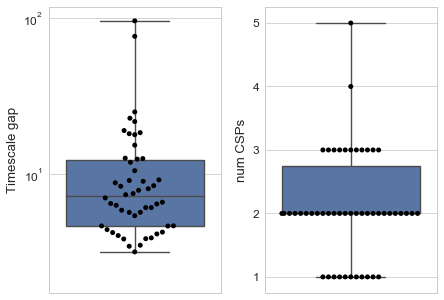

In [34]:
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt

with sns.plotting_context('paper', font_scale=1.5):
    fig, axes = plt.subplots(1, 2)
    ax = axes[0]
    sns.set_style('whitegrid')
    ax = sns.boxplot( y='gap', data=df, ax=ax, whis=100)
    ax = sns.swarmplot(y='gap', data=df, ax=ax, color='k')
    ax.set_yscale('log')
    ax.set_ylabel('Timescale gap')
    
    ax=axes[1]
    ax = sns.boxplot(y='n_csp', data=df, ax=ax, whis=100)    
    ax = sns.swarmplot(y='n_csp', data=df, ax=ax,color='k')


    ax.set_ylabel('num CSPs')
#     ax.yaxis.set_major_locator(ticker)
    plt.tight_layout()
    plt.savefig('figures/50cv_mle_timescales.png')